### Importing the necessary libraries

In [1]:
!pip install pydicom

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydicom
import os
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
import time
from os import listdir
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#color
from colorama import Fore, Back, Style

import seaborn as sns
sns.set(style="whitegrid")

#pydicom
import pydicom

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()


     |████████████████████████████████| 64 kB 1.8 MB/s eta 0:00:011


### Reading the training Dataset

In [6]:
INPUT_FOLDER = '../input/osic-pulmonary-fibrosis-progression/train/'

patients = os.listdir(INPUT_FOLDER)
patients.sort()

print("Some examples of patient IDs:")
print(",\n".join(patients[:5]))

Some examples of patient IDs:
ID00007637202177411956430,
ID00009637202177434476278,
ID00010637202177584971671,
ID00011637202177653955184,
ID00012637202177665765362


In [8]:
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/train/"

train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

print(Fore.YELLOW + 'Training data shape: ',Style.RESET_ALL,train_df.shape)
train_df.head(5)

Training data shape:   (1549, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [9]:
train_df.groupby(['SmokingStatus']).count()['Sex'].to_frame()

,Sex
SmokingStatus,
Currently smokes,82
Ex-smoker,1038
Never smoked,429


In [10]:
# Null values and Data types
print(Fore.YELLOW + 'Train Set !!',Style.RESET_ALL)
print(train_df.info())
print('-------------')
print(Fore.BLUE + 'Test Set !!',Style.RESET_ALL)
print(test_df.info())

Train Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB
None
-------------
Test Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non

In [11]:
train_df.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [12]:
test_df.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [13]:
# Total number of Patient in the dataset(train+test)

print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.BLUE +"Total Patients in Test set: ",Style.RESET_ALL,test_df['Patient'].count())

Total Patients in Train set:   1549
Total Patients in Test set:   5


In [15]:
files = folders = 0

path = "../input/osic-pulmonary-fibrosis-progression/train/"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files/images, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'folders/patients')

33,026  files/images, 176  folders/patients


In [16]:
print(Fore.YELLOW + "The total patient ids are",Style.RESET_ALL,f"{train_df['Patient'].count()},",
      Fore.BLUE + "from those the unique ids are", Style.RESET_ALL, f"{train_df['Patient'].value_counts().shape[0]}.")

The total patient ids are  1549, from those the unique ids are  176.


In [17]:
train_df['Patient'].value_counts().max()

#In train set, there are multiple rows for one 'Patient'. Because Patient has different weeks, FVC, Percent.

10

In [19]:
# Creating unique patient lists and their properties. 
train_dir = '../input/osic-pulmonary-fibrosis-progression/train/'
test_dir = '../input/osic-pulmonary-fibrosis-progression/test/'

patient_ids = os.listdir(train_dir)
patient_ids = sorted(patient_ids)

#Creating new rows
no_of_instances = []

for patient_id in patient_ids:
    patient_info = train_df[train_df['Patient'] == patient_id].reset_index()
    no_of_instances.append(len(os.listdir(train_dir + patient_id)))

#Creating the dataframe for the patient info    
patient_df = pd.DataFrame(list(zip(patient_ids, no_of_instances)), 
                                 columns =['Patient', 'no_of_DICOM_Slices'])
print(patient_df.info())
patient_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Patient             176 non-null    object
 1   no_of_DICOM_Slices  176 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB
None


,Patient,no_of_DICOM_Slices
0,ID00007637202177411956430,30
1,ID00009637202177434476278,394
2,ID00010637202177584971671,106
3,ID00011637202177653955184,31
4,ID00012637202177665765362,49


In [20]:
train_df['Weeks'].iplot(kind='hist',
                              xTitle='Weeks', 
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='#FB8072',
                              theme='pearl',
                              bargap=0.2,
                              gridcolor='white',
                              title='Distribution of the Weeks in the training set')

In [21]:
train_df['FVC'].value_counts()

2095    4
2889    4
2474    4
2965    4
2694    4
       ..
3313    1
3661    1
3299    1
5895    1
4096    1
Name: FVC, Length: 1202, dtype: int64

In [22]:
train_df['FVC'].iplot(kind='hist',
                      xTitle='Lung Capacity(ml)', 
                      linecolor='black', 
                      opacity=0.8,
                      color='#FB8072',
                      bargap=0.5,
                      gridcolor='white',
                      title='Distribution of the FVC in the training set')


In [23]:
fig = px.scatter(train_df, x="FVC", y="Percent", color='Age')
fig.show()

In [24]:
fig = px.scatter(train_df, x="FVC", y="Age", color='Sex')
fig.show()

In [25]:
fig = px.scatter(train_df, x="FVC", y="Weeks", color='SmokingStatus')
fig.show()

### Reading the DICOM images

In [26]:
print(Fore.YELLOW + 'Train .dcm number of images:',Style.RESET_ALL, len(list(os.listdir("../input/osic-pulmonary-fibrosis-progression/train/"))), '\n' +
      Fore.BLUE + 'Test .dcm number of images:',Style.RESET_ALL, len(list(os.listdir("../input/osic-pulmonary-fibrosis-progression/test/"))), '\n' +
      '--------------------------------', '\n' +
      'There is the same number of images as in train/ test .csv datasets')

Train .dcm number of images:  176 
Test .dcm number of images:  5 
-------------------------------- 
There is the same number of images as in train/ test .csv datasets


In [27]:
def plot_pixel_array(dataset, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.grid(False)
    plt.imshow(dataset.pixel_array, cmap='gray') # cmap=plt.cm.bone)
    plt.show()

total images for patient ID00123637202217151272140:  258


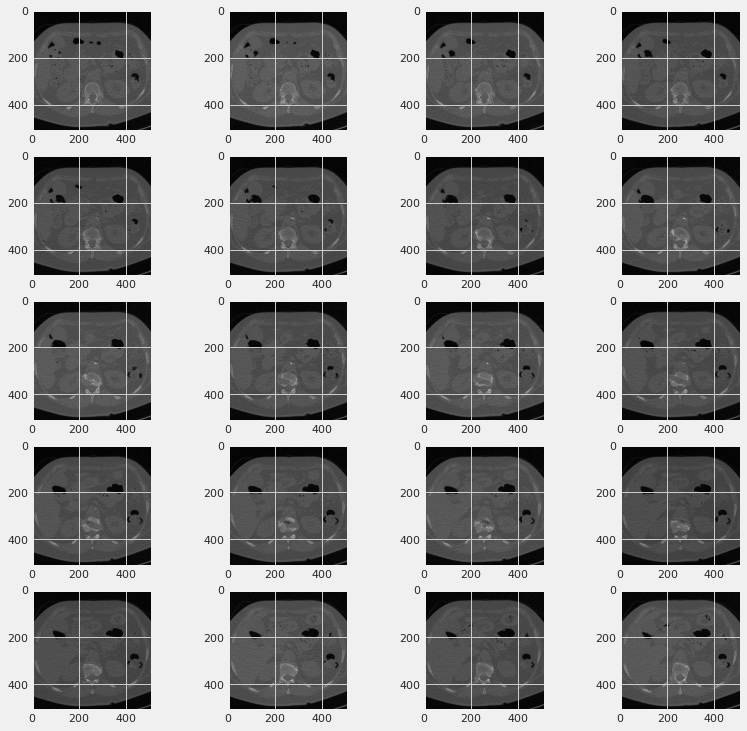

In [29]:
imdir = "../input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

In [30]:
def load_scan(path):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    
    slices = [pydicom.read_file(path+'/'+s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [31]:
def get_pixels_hu(scans):
    """
    Converts raw images to Hounsfield Units (HU).
    
    Parameters: scans (Raw images)
    
    Returns: image (NumPy array)
    """
    
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)

    # Since the scanning equipment is cylindrical in nature and image output is square,
    # we set the out-of-scan pixels to 0
    image[image == -2000] = 0
    
    
    # HU = m*P + b
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [32]:
test_patient_scans = load_scan(INPUT_FOLDER + patients[24])
test_patient_images = get_pixels_hu(test_patient_scans)

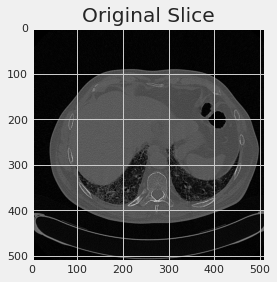

In [33]:
plt.imshow(test_patient_images[20], cmap='gray')
plt.title("Original Slice")
plt.show()

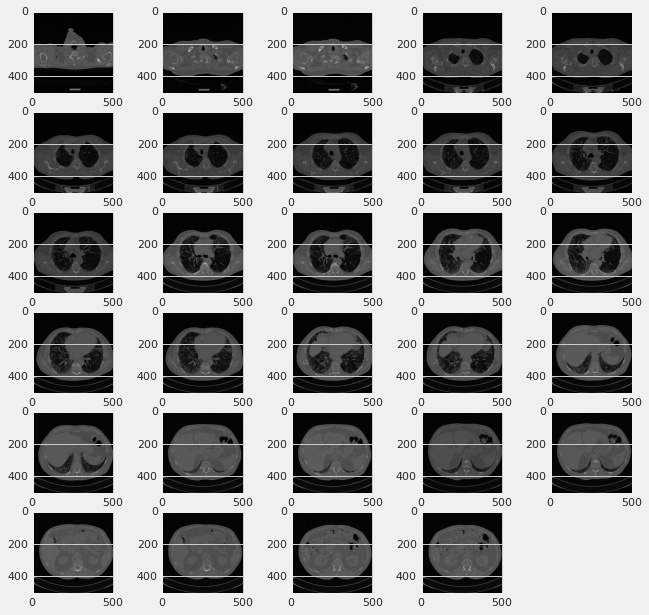

In [34]:


fig=plt.figure(figsize=(10,10))
columns = 5
rows = 6
for i in range(1, columns*rows ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_patient_images[i], cmap='gray')

### Masking

In [35]:
def generate_markers(image):
    """
    Generates markers for a given image.
    
    Parameters: image
    
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

In [42]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented

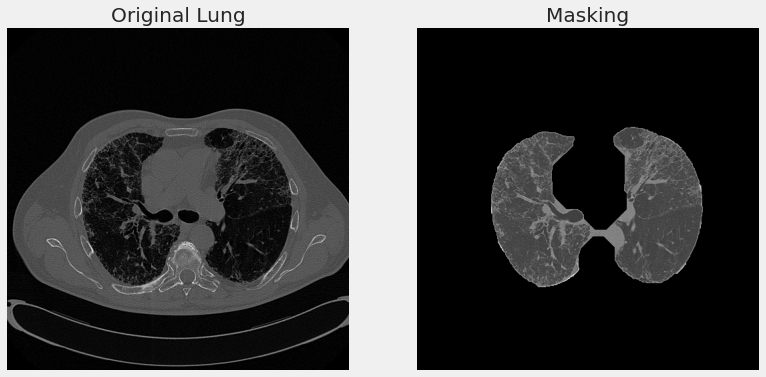

In [43]:
test_segmented=seperate_lungs(test_patient_images[12])
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12, 12))

ax1.imshow(test_patient_images[12], cmap='gray')
ax1.set_title("Original Lung")
ax1.axis('off')

ax2.imshow(test_segmented, cmap='gray')
ax2.set_title("Masking")
ax2.axis('off')

plt.show()

In [39]:
def plot_segment_images(n):
    patient_scans = load_scan(INPUT_FOLDER + patients[n])
    patient_images = get_pixels_hu(patient_scans)
    fig=plt.figure(figsize=(10,10))
    columns = 5
    rows = 6
    for i in range(1, columns*rows ):
        test_segmented=seperate_lungs(patient_images[i])
        fig.add_subplot(rows, columns, i)
        plt.imshow(test_segmented, cmap='gray')

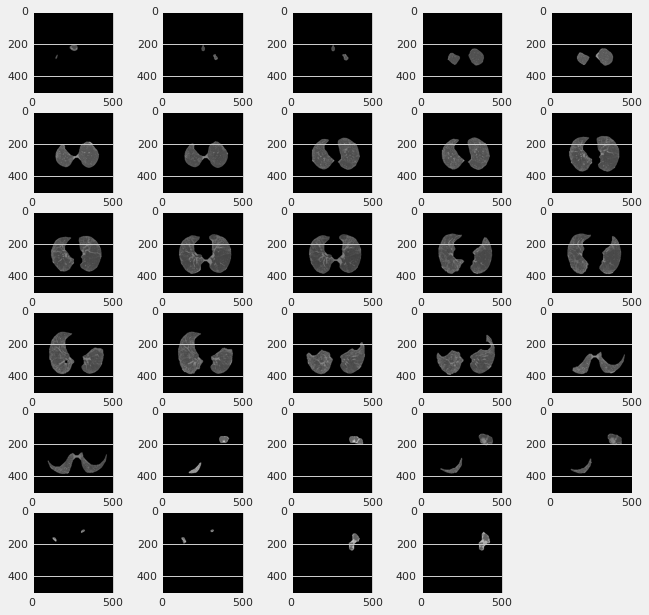

In [40]:
plot_segment_images(24)
    

In [47]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=72337b51013e98e0eb3d0a6b4bc49af212228fe61a6dd59a1ad149007214b93f
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=4b984cbaaee303738ebf44e84de5a19c1e3d77c056e885ddd514f70bf11797d0
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [48]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import tensorflow.keras.applications as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns

In [49]:

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [50]:
EPOCHS = 30
BATCH_SIZE = 8
LR = 0.003
SAVE_BEST = True
MODEL_CLASS = 'b5'

In [52]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')

In [53]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [54]:
train.SmokingStatus.unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

In [55]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0].lower() == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector)

In [56]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

In [57]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

In [66]:
x, y = [], []
for p in tqdm(train.Patient.unique()):
    try:
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/{p}/')
        numb = [float(i[:-4]) for i in ldir]
        for i in ldir:
            x.append(cv2.imread(f'../input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/{p}/{i}', 0).mean())
            y.append(float(i[:-4]) / max(numb))
    except:
        pass

In [67]:
train.Patient.values

array(['ID00007637202177411956430', 'ID00007637202177411956430',
       'ID00007637202177411956430', ..., 'ID00426637202313170790466',
       'ID00426637202313170790466', 'ID00426637202313170790466'],
      dtype=object)

In [68]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [69]:
def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    return model

In [65]:
P = np.array(P)
h=IGenerator(keys=P, 
                               a = A, 
                               tab = TAB)

In [ ]:
P = np.array(P)
subs = []
folds_history = []
    
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'effnet_{EPOCHS}.h5',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=SAVE_BEST,
    mode='auto'
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    verbose=1, 
    min_lr=1e-8
)
model = build_model(model_class=MODEL_CLASS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mae") 
history = model.fit_generator(IGenerator(keys=P, 
                               a = A, 
                               tab = TAB), 
                    steps_per_epoch = 32,
                    validation_data=IGenerator(keys=P, 
                               a = A, 
                               tab = TAB),
                    validation_steps = 16, 
                    callbacks = [cpt, rlp], 
                    epochs=EPOCHS)
folds_history.append(history.history)
print('Training done!')